# Load Data

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Ekstrak file jika perlu
output = './House_Room_Dataset.zip'

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("./Dataset")  # Ekstrak ke folder dataset_destinasi


In [ ]:
# Parameters
DATASET_DIR = "./Dataset/House_Room_Dataset"
CLASSES = ["Livingroom", "Kitchen", "Dinning", "Bedroom", "Bathroom"]
batch_size = 32
epochs = 20
learning_rate = 0.001
train_ratio = 0.7
val_ratio = 0.15

In [ ]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load Dataset
dataset = datasets.ImageFolder(DATASET_DIR, transform=transform)
data_size = len(dataset)
train_size = int(data_size * train_ratio)
val_size = int(data_size * val_ratio)
test_size = data_size - train_size - val_size

# Splitting Data

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 3674
Validation dataset size: 787
Test dataset size: 789


# Model

In [ ]:
# Define CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 56 * 56, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
num_classes = len(CLASSES)
print("Number of classes:", num_classes)

Number of classes: 5


In [ ]:
cnn_model = SimpleCNN(num_classes)
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(CLASSES))

In [ ]:
# Fungsi Latih Model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses, accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate on validation set
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        accuracy = correct / len(val_loader.dataset)
        accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, val_losses, accuracies

In [ ]:
# Fungsi Untuk Evaluasi Model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=dataset.classes))


In [ ]:
# Learning Curve
def plot_learning_curve(train_losses, val_losses, accuracies):
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.legend(loc="best")
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracies, label="Accuracy")
    plt.legend(loc="best")
    plt.title("Accuracy Curve")
    plt.show()

## CNN

In [ ]:
# Training CNN
cnn_model = cnn_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

cnn_train_losses, cnn_val_losses, cnn_accuracies = train_model(
    cnn_model, train_loader, val_loader, criterion, optimizer, epochs
)

Epoch 1/20, Train Loss: 2.5227, Val Loss: 1.5944, Accuracy: 0.2618
Epoch 2/20, Train Loss: 1.5884, Val Loss: 1.5766, Accuracy: 0.2618
Epoch 3/20, Train Loss: 1.5819, Val Loss: 1.5754, Accuracy: 0.2618
Epoch 4/20, Train Loss: 1.5807, Val Loss: 1.5736, Accuracy: 0.2618
Epoch 5/20, Train Loss: 1.5665, Val Loss: 1.5087, Accuracy: 0.2859
Epoch 6/20, Train Loss: 1.4714, Val Loss: 1.5100, Accuracy: 0.3062
Epoch 7/20, Train Loss: 1.3832, Val Loss: 1.4335, Accuracy: 0.3558
Epoch 8/20, Train Loss: 1.3400, Val Loss: 1.4011, Accuracy: 0.3685
Epoch 9/20, Train Loss: 1.3001, Val Loss: 1.3778, Accuracy: 0.3964
Epoch 10/20, Train Loss: 1.2523, Val Loss: 1.3765, Accuracy: 0.4168
Epoch 11/20, Train Loss: 1.2138, Val Loss: 1.3426, Accuracy: 0.4193
Epoch 12/20, Train Loss: 1.1826, Val Loss: 1.3869, Accuracy: 0.4066
Epoch 13/20, Train Loss: 1.1431, Val Loss: 1.3343, Accuracy: 0.4396
Epoch 14/20, Train Loss: 1.0807, Val Loss: 1.3245, Accuracy: 0.4816
Epoch 15/20, Train Loss: 1.0484, Val Loss: 1.3492, Accura

In [ ]:
evaluate_model(cnn_model, test_loader)

Accuracy: 0.4968314321926489
Classification Report:
               precision    recall  f1-score   support

    Bathroom       0.54      0.48      0.51        88
     Bedroom       0.62      0.34      0.44       203
     Dinning       0.57      0.57      0.57       174
     Kitchen       0.41      0.50      0.45       147
  Livingroom       0.44      0.61      0.51       177

    accuracy                           0.50       789
   macro avg       0.52      0.50      0.50       789
weighted avg       0.52      0.50      0.49       789



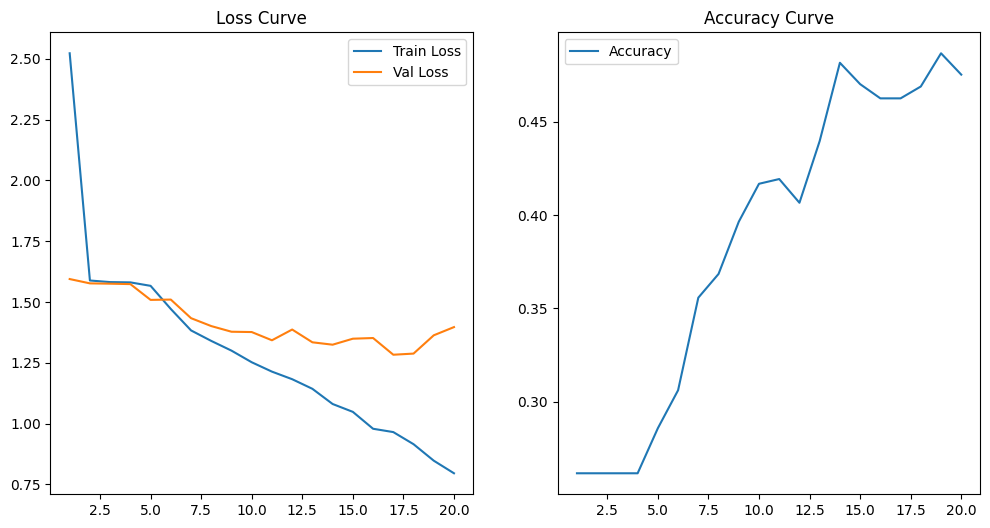

In [ ]:
plot_learning_curve(cnn_train_losses, cnn_val_losses, cnn_accuracies)

In [ ]:
# Save CNN Model
torch.save(cnn_model.state_dict(), "cnn_model.pth")

## ResNet

In [ ]:
# Training ResNet
resnet_model = resnet_model.cuda()
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)

resnet_train_losses, resnet_val_losses, resnet_accuracies = train_model(
    resnet_model, train_loader, val_loader, criterion, optimizer, epochs
)

Epoch 1/20, Train Loss: 0.9065, Val Loss: 1.1620, Accuracy: 0.5921
Epoch 2/20, Train Loss: 0.6155, Val Loss: 0.9495, Accuracy: 0.6900
Epoch 3/20, Train Loss: 0.5332, Val Loss: 0.7117, Accuracy: 0.7637
Epoch 4/20, Train Loss: 0.4567, Val Loss: 1.0119, Accuracy: 0.6747
Epoch 5/20, Train Loss: 0.4249, Val Loss: 1.2465, Accuracy: 0.5870
Epoch 6/20, Train Loss: 0.3712, Val Loss: 0.6202, Accuracy: 0.8018
Epoch 7/20, Train Loss: 0.3325, Val Loss: 0.6395, Accuracy: 0.8056
Epoch 8/20, Train Loss: 0.2954, Val Loss: 0.7157, Accuracy: 0.7929
Epoch 9/20, Train Loss: 0.2853, Val Loss: 0.7613, Accuracy: 0.7700
Epoch 10/20, Train Loss: 0.2478, Val Loss: 0.7076, Accuracy: 0.8056
Epoch 11/20, Train Loss: 0.2668, Val Loss: 0.6129, Accuracy: 0.8094
Epoch 12/20, Train Loss: 0.2165, Val Loss: 0.6585, Accuracy: 0.8094
Epoch 13/20, Train Loss: 0.2115, Val Loss: 0.5904, Accuracy: 0.8272
Epoch 14/20, Train Loss: 0.1719, Val Loss: 0.7052, Accuracy: 0.8081
Epoch 15/20, Train Loss: 0.1949, Val Loss: 0.6697, Accura

In [ ]:
evaluate_model(resnet_model, test_loader)

Accuracy: 0.8504435994930292
Classification Report:
               precision    recall  f1-score   support

    Bathroom       0.83      0.93      0.88        88
     Bedroom       0.94      0.86      0.90       203
     Dinning       0.89      0.80      0.84       174
     Kitchen       0.78      0.86      0.82       147
  Livingroom       0.80      0.84      0.82       177

    accuracy                           0.85       789
   macro avg       0.85      0.86      0.85       789
weighted avg       0.86      0.85      0.85       789



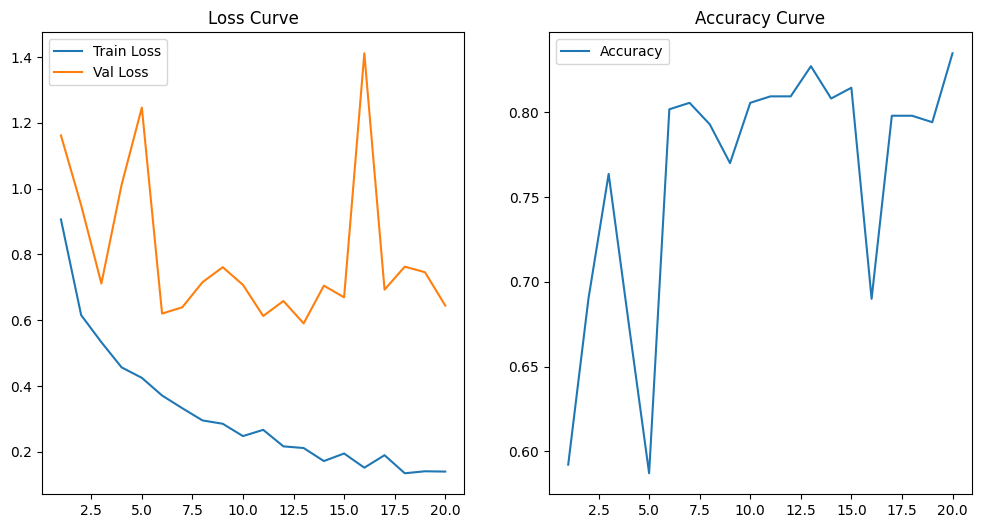

In [ ]:
plot_learning_curve(resnet_train_losses, resnet_val_losses, resnet_accuracies)

In [ ]:
# Save ResNet Model
torch.save(resnet_model.state_dict(), "resnet_model.pth")